In [1]:
# mount drive
# from google.colab import drive
# drive.mount('/content/drive')

# file path
file_path = './kenya_fraud_detection.csv'



In [2]:
# import pandas
import pandas as pd

# load dataset

df = pd.read_csv(file_path)

# Quick look at the dataset
print("Shape:", df.shape)   # rows, columns
print("\nColumns:", df.columns.tolist())

# View first few rows
print("\nSample rows:")
print(df.head())

# Dataset info
print("\nInfo:")
print(df.info())

# Summary stats (numerical only)
print("\nSummary statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

Shape: (10000, 14)

Columns: ['Unnamed: 0', 'transaction_id', 'user_id', 'transaction_type', 'amount', 'location', 'device_type', 'network_provider', 'user_type', 'time_of_day(morning, afternoon, evening, night)', 'is_foreign_number', 'is_sim_recently_swapped', 'has_multiple_accounts', 'datetime']

Sample rows:
   Unnamed: 0 transaction_id    user_id transaction_type   amount  location  \
0           0       TX100000  user_8270    Withdraw Cash  2646.35    Nakuru   
1           1       TX100001  user_1860       Send Money  2844.69   Garissa   
2           2       TX100002  user_6390     Deposit Cash  2384.46     Nyeri   
3           3       TX100003  user_6191    Withdraw Cash  1846.01   Nairobi   
4           4       TX100004  user_6734     Send   Money  1017.60  Machakos   

     device_type network_provider   user_type  \
0  Feature Phone     Telkom Kenya  individual   
1            iOS        Safaricom       agent   
2  Feature Phone     Telkom Kenya       agent   
3            iOS

In [3]:
#  delete unnamed column

df.head()

#  clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# drop time_of_day(morning,_afternoon,_evening,_night)
df = df.drop(['time_of_day(morning,_afternoon,_evening,_night)'], axis=1)
df = df.drop(['unnamed:_0'], axis=1)

# convert datetime to pandas datetime
df['datetime'] = pd.to_datetime(df['datetime'])

#  extract useful features
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.day_name()

# set time of day (morning,afternoon, evening, night) include 0 bin

def map_time_of_day(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"

# Create new column
df["time_of_day"] = df["hour"].apply(map_time_of_day)

# check missing values
print('missing values', df.isnull().sum())



df.head()

missing values transaction_id             0
user_id                    0
transaction_type           0
amount                     0
location                   0
device_type                0
network_provider           0
user_type                  0
is_foreign_number          0
is_sim_recently_swapped    0
has_multiple_accounts      0
datetime                   0
year                       0
month                      0
day                        0
hour                       0
day_of_week                0
time_of_day                0
dtype: int64


,transaction_id,user_id,transaction_type,amount,location,device_type,network_provider,user_type,is_foreign_number,is_sim_recently_swapped,has_multiple_accounts,datetime,year,month,day,hour,day_of_week,time_of_day
0,TX100000,user_8270,Withdraw Cash,2646.35,Nakuru,Feature Phone,Telkom Kenya,individual,0,0,0,2024-06-16 21:45:13,2024,6,16,21,Sunday,Night
1,TX100001,user_1860,Send Money,2844.69,Garissa,iOS,Safaricom,agent,0,0,0,2024-06-05 00:49:25,2024,6,5,0,Wednesday,Night
2,TX100002,user_6390,Deposit Cash,2384.46,Nyeri,Feature Phone,Telkom Kenya,agent,0,0,1,2024-06-13 15:54:02,2024,6,13,15,Thursday,Afternoon
3,TX100003,user_6191,Withdraw Cash,1846.01,Nairobi,iOS,Safaricom,individual,0,0,1,2024-06-10 01:05:49,2024,6,10,1,Monday,Night
4,TX100004,user_6734,Send Money,1017.60,Machakos,Feature Phone,Telkom Kenya,individual,0,0,0,2024-06-27 02:28:53,2024,6,27,2,Thursday,Night


In [4]:
# Preparing for Isolation Forest
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['transaction_type', 'location', 'device_type', 'network_provider', 'user_type', 'time_of_day', 'day_of_week']

# Initialize encorder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop first to avoid multicollinearity


# Fit and transform
encoded_data = encoder.fit_transform(df[categorical_cols])

# Create a new DataFrame with the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

#  Merge with original dataframe (drop original columns)
df_model = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

df_model.head()

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
## Feature Engineering

# Transactions per user
df_model['date'] = df_model['datetime'].dt.date
user_txn_count = df_model.groupby(['user_id', 'date'])['transaction_id'].count().reset_index()
user_txn_count.rename(columns={'transaction_id': 'txn_count_count_per_day'}, inplace=True)

# Drop the potentially existing column before merging
if 'txn_count_count_per_day' in df_model.columns:
    df_model = df_model.drop('txn_count_count_per_day', axis=1)

# Merge back to main dataframe
df_model = pd.merge(df_model, user_txn_count, on=['user_id', 'date'], how='left')

# Average transaction amount per user
user_avg_txn_amt = df_model.groupby(['user_id'])['amount'].mean().reset_index()
user_avg_txn_amt.rename(columns={'amount': 'avg_txn_amt'}, inplace=True)

# Drop the potentially existing column before merging
if 'avg_txn_amt' in df_model.columns:
    df_model = df_model.drop('avg_txn_amt', axis=1)

# Merge
df_model = pd.merge(df_model, user_avg_txn_amt, on=['user_id'], how='left')

# Amount deviation (current txn vs user avg)
df_model['txn_amt_deviation'] = df_model['amount'] - df_model['avg_txn_amt']

# Signal midnight txns (usualy suspicious)
df_model['is_night_txn'] = df['time_of_day'].apply(lambda x: 1 if x == 'night' else 0)

#  Risk Score for swapped SIM and multiple accounts
df_model['sim_multiple_risk_score'] = df_model['is_sim_recently_swapped'] + df_model['has_multiple_accounts']

# Foreign number high amount
df_model['foreign_high_amt'] = df_model['is_foreign_number'] * df_model['amount']

# Count number of locations per user
user_location_count = df.groupby(['user_id'])['location'].nunique().reset_index()
user_location_count.rename(columns={'location': 'unique_location_count'}, inplace=True)

# Drop the potentially existing column before merging
if 'unique_location_count' in df_model.columns:
    df_model = df_model.drop('unique_location_count', axis=1)

# Merge
df_model = pd.merge(df_model, user_location_count, on=['user_id'], how='left')

In [ ]:
# Scaling Numerical Features
from sklearn.preprocessing import StandardScaler

numerical_cols = [
    'amount','month','day','hour',
    'is_foreign_number', 'is_sim_recently_swapped', 'has_multiple_accounts',
    'txn_count_count_per_day','avg_txn_amt','txn_amt_deviation',
    'is_night_txn','sim_multiple_risk_score','foreign_high_amt',
    'unique_location_count'
    ]


# Initialize scaler
scaler = StandardScaler()
df_model[numerical_cols] = scaler.fit_transform(df_model[numerical_cols])

print(df_model.shape)
df_model.head()

(10000, 55)


,transaction_id,user_id,amount,is_foreign_number,is_sim_recently_swapped,has_multiple_accounts,datetime,year,month,day,...,day_of_week_Tuesday,day_of_week_Wednesday,date,txn_count_count_per_day,avg_txn_amt,txn_amt_deviation,is_night_txn,sim_multiple_risk_score,foreign_high_amt,unique_location_count
0,TX100000,user_8270,-0.242381,-0.184443,-0.23373,-0.326063,2024-06-16 21:45:13,2024,0.0,0.134048,...,0.0,0.0,2024-06-16,-0.190192,-0.313275,-1.964767e-18,0.0,-0.402197,-0.123837,-1.044113
1,TX100001,user_1860,-0.185828,-0.184443,-0.23373,-0.326063,2024-06-05 00:49:25,2024,0.0,-1.176529,...,0.0,1.0,2024-06-05,-0.190192,-0.240180,-1.964767e-18,0.0,-0.402197,-0.123837,-1.044113
2,TX100002,user_6390,-0.317055,-0.184443,-0.23373,3.066892,2024-06-13 15:54:02,2024,0.0,-0.223382,...,0.0,0.0,2024-06-13,-0.190192,-0.445002,4.300165e-02,0.0,2.317187,-0.123837,0.057040
3,TX100003,user_6191,-0.470586,-0.184443,-0.23373,3.066892,2024-06-10 01:05:49,2024,0.0,-0.580812,...,0.0,0.0,2024-06-10,-0.190192,0.100367,-8.653466e-01,0.0,2.317187,-0.123837,0.057040
4,TX100004,user_6734,-0.706795,-0.184443,-0.23373,-0.326063,2024-06-27 02:28:53,2024,0.0,1.444625,...,0.0,0.0,2024-06-27,-0.190192,-0.913523,-1.964767e-18,0.0,-0.402197,-0.123837,-1.044113


In [ ]:
from sklearn.ensemble import IsolationForest

# Select model-ready features exclude IDs and datetime columns
features_model = [col for col in df_model.columns if col not in ['transaction_id', 'user_id', 'datetime', 'date']]

X = df_model[features_model]

# Initialize model
iso = IsolationForest(
    n_estimators=200,
    max_samples='auto',
    contamination=0.02,
    random_state=42)

# Fit model
iso.fit(X)

# Predict anomalies
df_model['anomaly_score'] = iso.decision_function(X)
df_model['anomaly_label'] = iso.predict(X)

df_model['is_fraud_predicted'] = df_model['anomaly_label'].map({1:0,-1:1})

# Merge results back to original df
df['anomaly_score'] = df_model['anomaly_score']
# df['anomaly_label'] = df_model['anomaly_label']
df['is_fraud_predicted'] = df_model['is_fraud_predicted']

print(df['is_fraud_predicted'].value_counts())

# View top suspicious transactions
df[['transaction_id','user_id','amount','anomaly_score','is_fraud_predicted']].sort_values('anomaly_score').head(10)


is_fraud_predicted
0    9800
1     200
Name: count, dtype: int64


,transaction_id,user_id,amount,anomaly_score,is_fraud_predicted
9551,TX109551,user_3400,5598.04,-0.059757,1
4292,TX104292,user_9970,25058.95,-0.053364,1
4716,TX104716,user_2478,8257.38,-0.045887,1
2893,TX102893,user_9043,9156.24,-0.043595,1
1378,TX101378,user_4093,10451.72,-0.042554,1
1005,TX101005,user_1054,6241.46,-0.040687,1
5211,TX105211,user_5565,1066.75,-0.040124,1
2044,TX102044,user_2256,2651.17,-0.039499,1
5140,TX105140,user_6596,956.01,-0.038796,1
991,TX100991,user_1768,4725.71,-0.038249,1


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Count anomalies
n_anomalies = df_model[df_model['is_fraud_predicted'] == 1].shape[0]
n_total = df_model.shape[0]
print(f"Anomalies detected: {n_anomalies} ({n_anomalies/n_total:.2%})")

Anomalies detected: 200 (2.00%)


In [ ]:
# Count anomalies vs normal
anomaly_counts = df_model['is_fraud_predicted'].value_counts()
print("Inliers:", anomaly_counts.get(0, 0))
print("Anomalies:", anomaly_counts.get(1, 0))

Inliers: 9800
Anomalies: 200


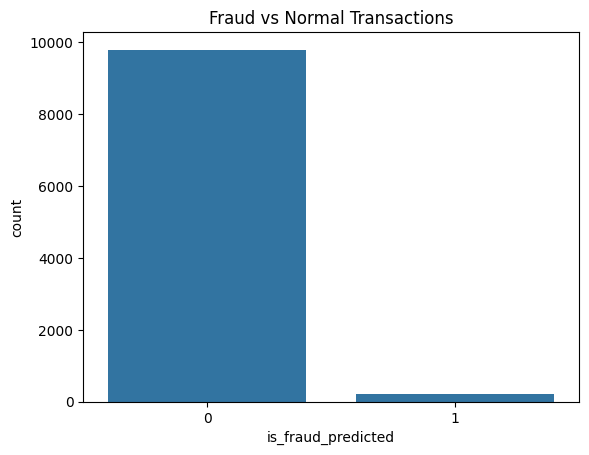

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='is_fraud_predicted')
plt.title("Fraud vs Normal Transactions")
plt.show()


In [ ]:
# 2. Inspect anomalies vs normal
anomalies = df_model[df_model['is_fraud_predicted'] == 1]
normals = df_model[df_model['is_fraud_predicted'] == 0]

print("\nAnomaly Transactions Summary:")
(anomalies.describe())


Anomaly Transactions Summary:


,amount,is_foreign_number,is_sim_recently_swapped,has_multiple_accounts,datetime,year,month,day,hour,transaction_type_ Buy Airtime,...,txn_count_count_per_day,avg_txn_amt,txn_amt_deviation,is_night_txn,sim_multiple_risk_score,foreign_high_amt,unique_location_count,anomaly_score,anomaly_label,is_fraud_predicted
count,200.000000,200.000000,200.000000,200.000000,200,200.0,200.0,200.000000,200.000000,200.0,...,200.000000,200.000000,2.000000e+02,200.0,200.000000,200.000000,200.000000,200.000000,200.0,200.0
mean,0.799759,1.665593,1.661380,1.557027,2024-06-14 21:42:32.425000192,2024.0,0.0,-0.058964,0.069858,0.0,...,0.481951,0.730161,3.706602e-01,0.0,2.249203,2.133855,0.321316,-0.013570,-1.0,1.0
min,-0.993483,-0.184443,-0.233730,-0.326063,2024-06-01 00:46:54,2024.0,0.0,-1.653102,-1.673700,0.0,...,-0.190192,-1.267204,-3.709383e+00,0.0,-0.402197,-0.123837,-1.044113,-0.059757,-1.0,1.0
25%,-0.628929,-0.184443,-0.233730,-0.326063,2024-06-05 17:13:42.500000,2024.0,0.0,-1.176529,-0.843434,0.0,...,-0.190192,-0.485662,-4.277137e-01,0.0,2.317187,-0.123837,-1.044113,-0.018858,-1.0,1.0
50%,-0.023686,-0.184443,-0.233730,3.066892,2024-06-15 02:54:36,2024.0,0.0,0.014905,0.059028,0.0,...,-0.190192,0.217597,-1.964767e-18,0.0,2.317187,-0.123837,0.057040,-0.010102,-1.0,1.0
75%,2.018574,5.421728,4.278437,3.066892,2024-06-23 07:06:53.500000,2024.0,0.0,0.968052,1.069786,0.0,...,-0.190192,1.444392,7.466964e-01,0.0,2.317187,1.602144,1.158193,-0.004397,-1.0,1.0
max,7.620197,5.421728,4.278437,3.066892,2024-06-29 18:50:32,2024.0,0.0,1.682912,1.647362,0.0,...,4.788646,8.471736,7.906115e+00,0.0,5.036571,28.630531,3.360498,-0.000021,-1.0,1.0
std,1.844316,2.642708,2.232607,1.690414,NaN,0.0,0.0,1.075947,1.071191,0.0,...,1.705656,1.700929,1.797563e+00,0.0,1.622895,5.057894,1.225496,0.011648,0.0,0.0


In [ ]:
print("\nNormal Transactions Summary:")
(normals.describe())


Normal Transactions Summary:


,amount,is_foreign_number,is_sim_recently_swapped,has_multiple_accounts,datetime,year,month,day,hour,transaction_type_ Buy Airtime,...,txn_count_count_per_day,avg_txn_amt,txn_amt_deviation,is_night_txn,sim_multiple_risk_score,foreign_high_amt,unique_location_count,anomaly_score,anomaly_label,is_fraud_predicted
count,9800.000000,9800.000000,9800.000000,9800.000000,9800,9800.0,9800.0,9800.000000,9800.000000,9800.000000,...,9800.000000,9800.000000,9.800000e+03,9800.0,9800.000000,9800.000000,9800.000000,9.800000e+03,9800.0,9800.0
mean,-0.016322,-0.033992,-0.033906,-0.031776,2024-06-15 09:19:12.028367360,2024.0,0.0,0.001203,-0.001426,0.000102,...,-0.009836,-0.014901,-7.564494e-03,0.0,-0.045902,-0.043548,-0.006557,6.563031e-02,1.0,0.0
min,-0.996939,-0.184443,-0.233730,-0.326063,2024-06-01 00:01:11,2024.0,0.0,-1.653102,-1.673700,0.000000,...,-0.190192,-1.288284,-5.691108e+00,0.0,-0.402197,-0.123837,-1.044113,4.277760e-07,1.0,0.0
25%,-0.713763,-0.184443,-0.233730,-0.326063,2024-06-08 02:30:57.249999872,2024.0,0.0,-0.819099,-0.807336,0.000000,...,-0.190192,-0.714443,-3.393922e-01,0.0,-0.402197,-0.123837,-1.044113,5.012899e-02,1.0,0.0
50%,-0.319678,-0.184443,-0.233730,-0.326063,2024-06-15 05:32:51,2024.0,0.0,0.014905,0.059028,0.000000,...,-0.190192,-0.229452,-1.964767e-18,0.0,-0.402197,-0.123837,0.057040,6.812866e-02,1.0,0.0
75%,0.374978,-0.184443,-0.233730,-0.326063,2024-06-22 16:18:20.750000128,2024.0,0.0,0.848908,0.925392,0.000000,...,-0.190192,0.416636,2.055589e-01,0.0,-0.402197,-0.123837,0.057040,8.216491e-02,1.0,0.0
max,7.383113,5.421728,4.278437,3.066892,2024-06-29 23:59:33,2024.0,0.0,1.682912,1.647362,1.000000,...,9.767484,9.152465,7.931609e+00,0.0,5.036571,12.962018,3.360498,1.449337e-01,1.0,0.0
std,0.968562,0.906038,0.928332,0.954982,NaN,0.0,0.0,0.998464,0.998553,0.010102,...,0.978056,0.975015,9.757205e-01,0.0,0.928259,0.637300,0.993913,2.504992e-02,0.0,0.0


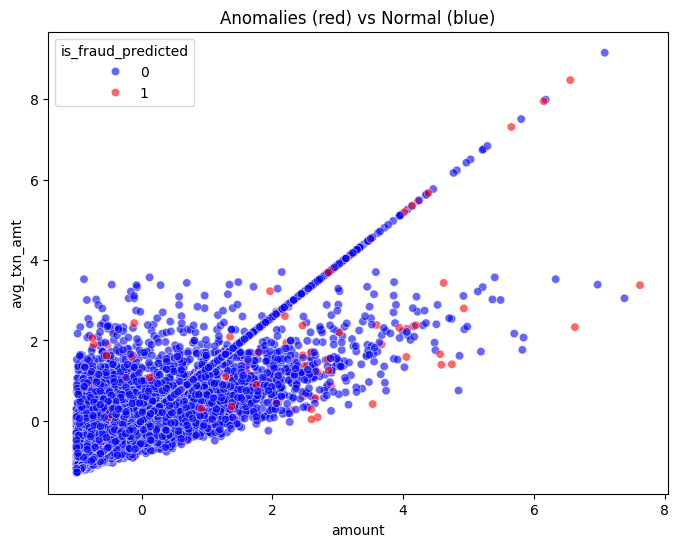

In [ ]:
# 3. Visualize anomalies in Amount vs Average Txn Amount
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='amount', y='avg_txn_amt',
    data=df_model, hue='is_fraud_predicted', palette={0: 'blue', 1: 'red'}, alpha=0.6
)
plt.title("Anomalies (red) vs Normal (blue)")
plt.show()

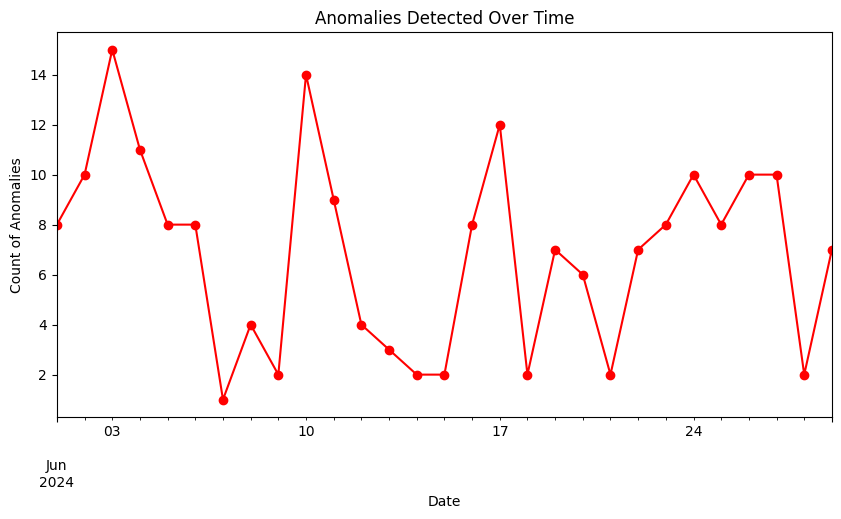

In [ ]:
# 4. Time-based anomaly detection trends
df_model['date'] = pd.to_datetime(df_model['date'])  # ensure datetime
anomaly_trend = df_model.groupby('date')['is_fraud_predicted'].apply(lambda x: (x==1).sum())

plt.figure(figsize=(10,5))
anomaly_trend.plot(kind='line', marker='o', color='red')
plt.title("Anomalies Detected Over Time")
plt.xlabel("Date")
plt.ylabel("Count of Anomalies")
plt.show()

In [ ]:
suspicious_indices = df_model[df_model['is_fraud_predicted'] == 1].sort_values(by='anomaly_score').head(10).index
suspicious_transactions_info = df.loc[suspicious_indices, ['transaction_id','user_id','amount','location','time_of_day']]
suspicious_transactions_info['risk_score'] = df_model.loc[suspicious_indices, 'sim_multiple_risk_score']
print(suspicious_transactions_info)

     transaction_id    user_id    amount  location time_of_day  risk_score
9551       TX109551  user_3400   5598.04    Kisumu     Morning    5.036571
4292       TX104292  user_9970  25058.95     Thika       Night    2.317187
4716       TX104716  user_2478   8257.38   Garissa   Afternoon    2.317187
2893       TX102893  user_9043   9156.24    Kisumu   Afternoon    2.317187
1378       TX101378  user_4093  10451.72    Kisumu     Evening    2.317187
1005       TX101005  user_1054   6241.46    Nakuru       Night    5.036571
5211       TX105211  user_5565   1066.75    Nakuru     Evening    5.036571
2044       TX102044  user_2256   2651.17     Nyeri     Evening    2.317187
5140       TX105140  user_6596    956.01     Thika       Night    2.317187
991        TX100991  user_1768   4725.71  Machakos     Evening   -0.402197


In [ ]:
user_anomalies = df_model.groupby('user_id')['is_fraud_predicted'].apply(lambda x: (x==-1).mean()).reset_index()
user_anomalies.rename(columns={'is_fraud_predicted':'anomaly_rate'}, inplace=True)
(user_anomalies.sort_values(by='anomaly_rate', ascending=False).head(10))


,user_id,anomaly_rate
6001,user_9998,0.0
0,user_1001,0.0
5985,user_9978,0.0
5984,user_9976,0.0
5983,user_9975,0.0
5982,user_9974,0.0
5981,user_9971,0.0
5980,user_9970,0.0
5979,user_9967,0.0
5978,user_9966,0.0


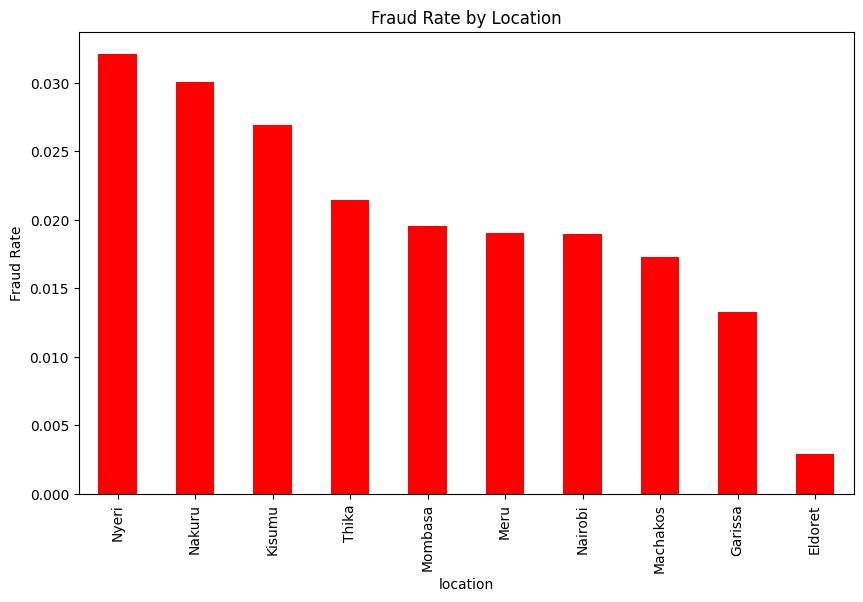

In [ ]:
fraud_by_location = df.groupby('location')['is_fraud_predicted'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
fraud_by_location.plot(kind='bar', color='red')
plt.title("Fraud Rate by Location")
plt.ylabel("Fraud Rate")
plt.show()


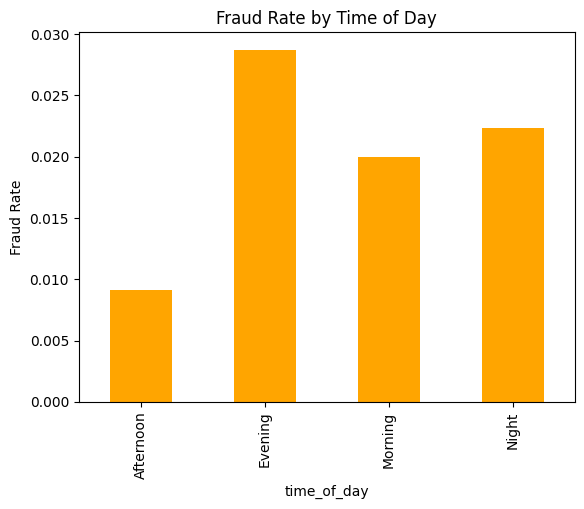

In [ ]:
fraud_by_time = df.groupby('time_of_day')['is_fraud_predicted'].mean()

fraud_by_time.plot(kind='bar', color='orange')
plt.title("Fraud Rate by Time of Day")
plt.ylabel("Fraud Rate")
plt.show()


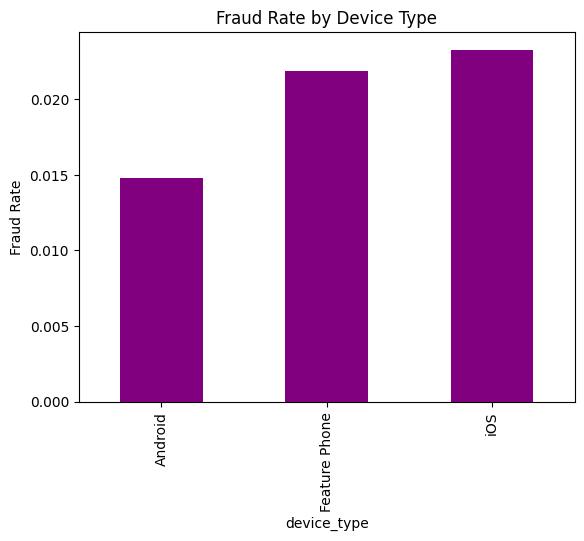

In [ ]:
fraud_by_device = df.groupby('device_type')['is_fraud_predicted'].mean()

fraud_by_device.plot(kind='bar', color='purple')
plt.title("Fraud Rate by Device Type")
plt.ylabel("Fraud Rate")
plt.show()


In [ ]:
user_fraud_rate = df.groupby('user_id')['is_fraud_predicted'].mean().sort_values(ascending=False)

print("Top 10 Suspicious Users:")
print(user_fraud_rate.head(10))


Top 10 Suspicious Users:
user_id
user_9767    1.0
user_8555    1.0
user_8052    1.0
user_9412    1.0
user_9783    1.0
user_4782    1.0
user_8581    1.0
user_7542    1.0
user_1166    1.0
user_5655    1.0
Name: is_fraud_predicted, dtype: float64


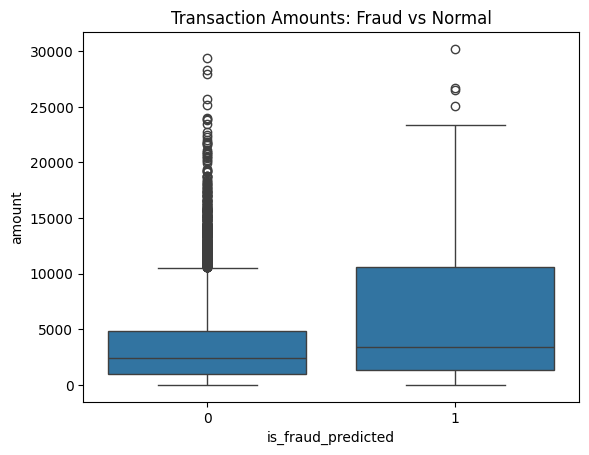

In [ ]:
sns.boxplot(data=df, x='is_fraud_predicted', y='amount')
plt.title("Transaction Amounts: Fraud vs Normal")
plt.show()


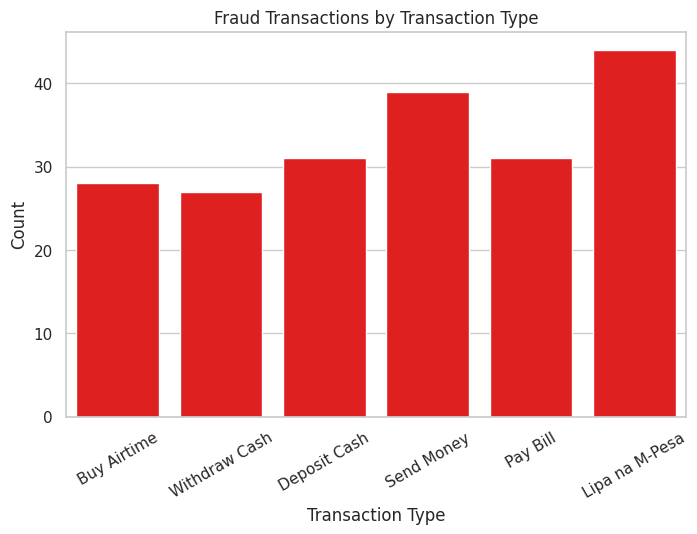

In [ ]:
# Set style
sns.set(style="whitegrid")

# Filter only predicted frauds
df_fraud = df[df['is_fraud_predicted'] == 1]

# Fraud by Transaction Type
plt.figure(figsize=(8,5))
sns.countplot(data=df_fraud, x="transaction_type", color='red')
plt.title("Fraud Transactions by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()

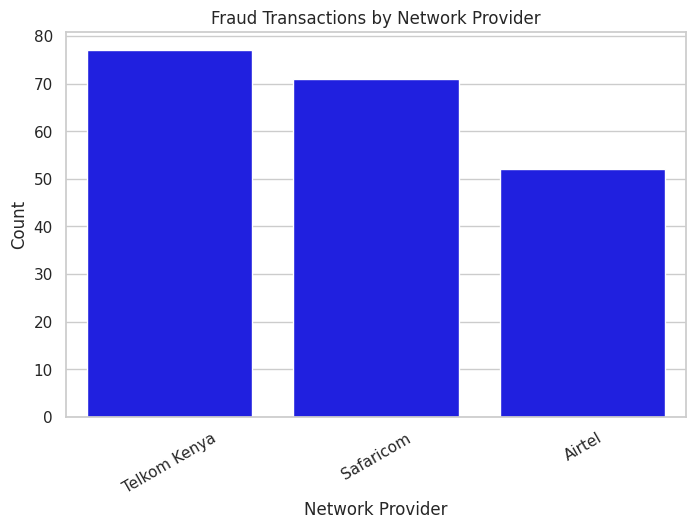

In [ ]:
# Fraud by Network Provider
plt.figure(figsize=(8,5))
sns.countplot(data=df_fraud, x="network_provider", color='blue')
plt.title("Fraud Transactions by Network Provider")
plt.xlabel("Network Provider")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()

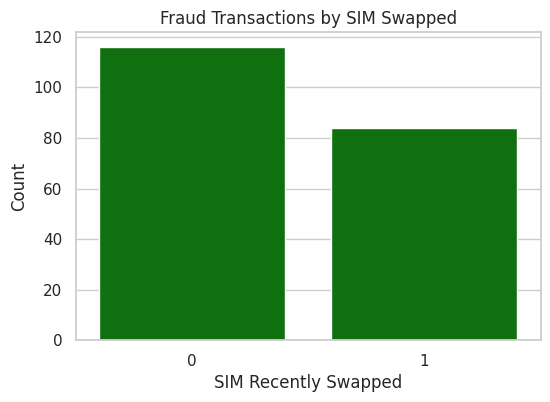

In [ ]:
# Fraud by SIM Swapped
plt.figure(figsize=(6,4))
sns.countplot(data=df_fraud, x="is_sim_recently_swapped", color='green')
plt.title("Fraud Transactions by SIM Swapped")
plt.xlabel("SIM Recently Swapped")
plt.ylabel("Count")
plt.show()